GP Regression with GPflow
--

*James Hensman, 2015, 2016*

GP regression (with Gaussian noise) is the most straightforward GP model in GPflow. Because of the conjugacy of the latent process and the noise, the marginal likelihood $p(\mathbf y\,|\,\theta)$ can be computed exactly.

This notebook shows how to build a GPR model, estimate the parameters $\theta$ by both maximum likelihood and MCMC. 

## Editted by @fujiisoup

In this note, I checked the updated umplementation where the model reuse with different data becomes possible.

Please see

model.update_data(X,Y)
gpr.update_data(X,Y)
vgp.update_data(X,Y)

In [1]:
import GPflow
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import time

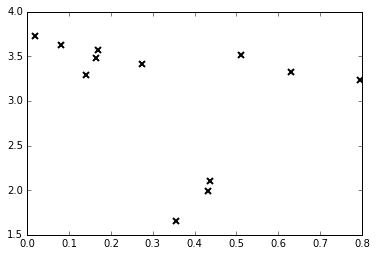

In [2]:
# build a very simple data set:
N = 12
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
plt.figure()
plt.plot(X, Y, 'kx', mew=2)

Maximum Likelihood estimation
--

In [3]:
#build the GPR object
k = GPflow.kernels.Matern52(1)
meanf = GPflow.mean_functions.Linear(1,0)
m = GPflow.gpr.GPR(X, Y, k, meanf)
m.likelihood.variance = 0.01

In [4]:
print "Here are the parameters before optimization"
m

Here are the parameters before optimization


Name,values,prior,constraint
model.likelihood.variance,[ 0.01],None,+ve
model.kern.lengthscales,[ 1.],None,+ve
model.kern.variance,[ 1.],None,+ve
model.mean_function.b,[ 0.],None,(none)
model.mean_function.A,[[ 1.]],None,(none)


In [5]:
t = time.time()
m.optimize()
print "Here are the parameters after optimization"
print time.time() - t, " (s) for compilation and optimization"
m

compiling tensorflow function...
done
optimization terminated, setting model state
Here are the parameters after optimization
0.924901008606  (s) for compilation and optimization


Name,values,prior,constraint
model.likelihood.variance,[ 0.0002338],None,+ve
model.kern.lengthscales,[ 0.08229101],None,+ve
model.kern.variance,[ 0.52987039],None,+ve
model.mean_function.b,[ 3.38831646],None,(none)
model.mean_function.A,[[-0.46689269]],None,(none)


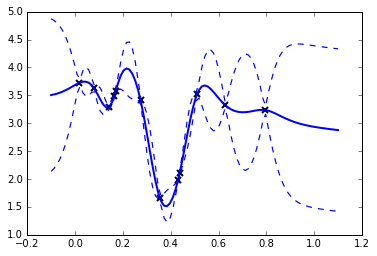

In [6]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)

### For another data

In [7]:
N = 12
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
# update data
m.X = X
m.Y = Y

In [8]:
t = time.time()
m.optimize()
print "Here are the parameters after optimization"
print time.time() - t, " (s) for optimization"
m

optimization terminated, setting model state
Here are the parameters after optimization
0.26092505455  (s) for optimization


Name,values,prior,constraint
model.likelihood.variance,[ 0.00210826],None,+ve
model.kern.lengthscales,[ 0.06330057],None,+ve
model.kern.variance,[ 0.60959048],None,+ve
model.mean_function.b,[ 3.53360553],None,(none)
model.mean_function.A,[[-0.83051389]],None,(none)


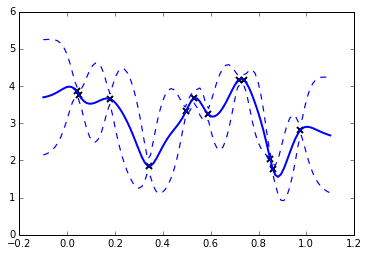

In [9]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)

### For another data with different shape

In [10]:
# shape changed!
N = 13
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
# update data
m.X = X
m.Y = Y

In [11]:
t = time.time()
m.optimize()
print "Here are the parameters after optimization"
print time.time() - t, " (s) for compilation and optimization"
m

compiling tensorflow function...
done
optimization terminated, setting model state
Here are the parameters after optimization
0.933229923248  (s) for compilation and optimization


Name,values,prior,constraint
model.likelihood.variance,[ 1.78981274e-11],None,+ve
model.kern.lengthscales,[ 0.02657308],None,+ve
model.kern.variance,[ 0.14218539],None,+ve
model.mean_function.b,[ 3.74946914],None,(none)
model.mean_function.A,[[-1.63917878]],None,(none)


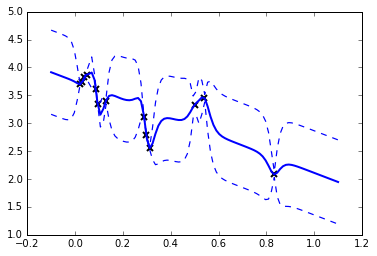

In [12]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)

## Fixing the parameters

In [13]:
# Fix the lengthscale
m.kern.lengthscales.fixed = True
m.kern.lengthscales = 0.1

In [14]:
t = time.time()
m.optimize()
print "Here are the parameters after optimization"
print time.time() - t, " (s) for compilation and optimization"
m

compiling tensorflow function...
done
optimization terminated, setting model state
Here are the parameters after optimization
0.80339884758  (s) for compilation and optimization


Name,values,prior,constraint
model.likelihood.variance,[ 1.78983495e-11],None,+ve
model.kern.lengthscales,[ 0.1],None,[FIXED]
model.kern.variance,[ 9.86309747],None,+ve
model.mean_function.b,[ 4.45501186],None,(none)
model.mean_function.A,[[-2.63885473]],None,(none)


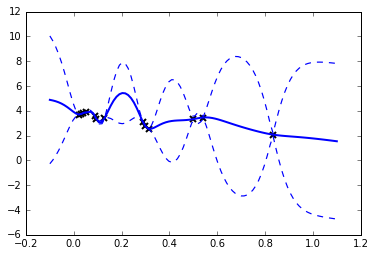

In [15]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)

### With different value for fixed param

In [16]:
# Change the lengthscale
m.kern.lengthscales = 0.2

In [17]:
t = time.time()
m.optimize()
print "Here are the parameters after optimization"
print time.time() - t, " (s) for optimization"
m

optimization terminated, setting model state
Here are the parameters after optimization
0.202425956726  (s) for optimization


Name,values,prior,constraint
model.likelihood.variance,[ 1.80748749e-11],None,+ve
model.kern.lengthscales,[ 0.2],None,[FIXED]
model.kern.variance,[ 253.72082089],None,+ve
model.mean_function.b,[ 6.28558073],None,(none)
model.mean_function.A,[[-5.6205361]],None,(none)


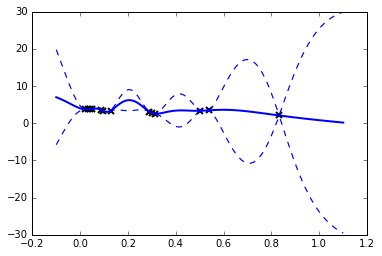

In [18]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)

MCMC
--
First, we'll set come priors on the kernel parameters, then we'll run mcmc and see how much posterior uncertainty there is in the parameters.

In [19]:
m.kern.lengthscales.fixed = False

In [20]:
#we'll choose rather arbitrary priors. 
m.kern.lengthscales.prior = GPflow.priors.Gamma(1., 1.)
m.kern.variance.prior = GPflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = GPflow.priors.Gamma(1., 1.)
m.mean_function.A.prior = GPflow.priors.Gaussian(0., 10.)
m.mean_function.b.prior = GPflow.priors.Gaussian(0., 10.)
m

Name,values,prior,constraint
model.likelihood.variance,[ 1.80748749e-11],"Ga([ 1.],[ 1.])",+ve
model.kern.lengthscales,[ 0.2],"Ga([ 1.],[ 1.])",+ve
model.kern.variance,[ 253.72082089],"Ga([ 1.],[ 1.])",+ve
model.mean_function.b,[ 6.28558073],"N([ 0.],[ 10.])",(none)
model.mean_function.A,[[-5.6205361]],"N([ 0.],[ 10.])",(none)


In [21]:
samples = m.sample(500, epsilon = 0.1, verbose=1)

compiling tensorflow function...
done
Iteration:  100 	 Acc Rate:  94.0 %
Iteration:  200 	 Acc Rate:  100.0 %
Iteration:  300 	 Acc Rate:  100.0 %
Iteration:  400 	 Acc Rate:  98.0 %
Iteration:  500 	 Acc Rate:  100.0 %


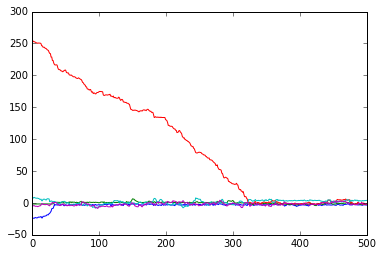

In [22]:
plt.figure()
plt.plot(samples)

/Users/james/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


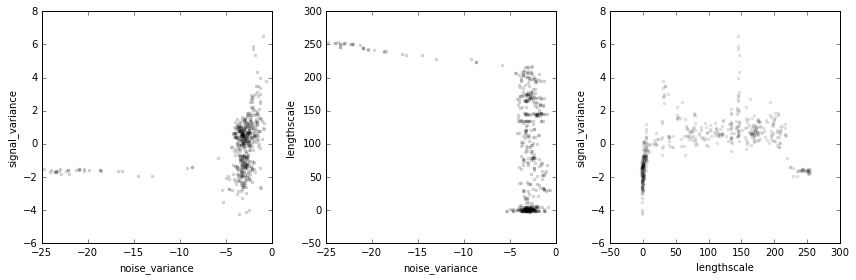

In [23]:
#Note. All these labels are wrong (or, most probably wrong). We need some machinery for labelling posterior samples!

f, axs = plt.subplots(1,3, figsize=(12,4), tight_layout=True)
axs[0].plot(samples[:,0], samples[:,1], 'k.', alpha = 0.15)
axs[0].set_xlabel('noise_variance')
axs[0].set_ylabel('signal_variance')
axs[1].plot(samples[:,0], samples[:,2], 'k.', alpha = 0.15)
axs[1].set_xlabel('noise_variance')
axs[1].set_ylabel('lengthscale')
axs[2].plot(samples[:,2], samples[:,1], 'k.', alpha = 0.1)
axs[2].set_xlabel('lengthscale')
axs[2].set_ylabel('signal_variance')

In [ ]:
#an attempt to plot the function posterior
#Note that we should really sample the function values here, instead of just using the mean. 
#We are under-representing the uncertainty here. 
# TODO: get full_covariance of the predictions (predict_f only?)

plt.figure()

for s in samples:
    m.set_state(s)
    mean, _ = m.predict_y(xx)
    plt.plot(xx, mean, 'b', lw=2, alpha = 0.05)
    
plt.plot(X, Y, 'kx', mew=2)

## Variational inference

In [ ]:
N = 25
X = np.arange(N).reshape(-1,1)
Y = 10.*np.exp(-((X-np.ones((N,1))*5.)*0.1)**2.) + np.random.rand(N,1)*3.

In [ ]:
#build the GPR object
k = GPflow.kernels.RBF(1)
lik = GPflow.likelihoods.Poisson()
m = GPflow.vgp.VGP(X, Y, k, likelihood=lik)

In [ ]:
t = time.time()
m.optimize()
print time.time() - t, " (s) for compilation and optimization" 

In [ ]:
#plot!
xx = np.linspace(-1., N+1., 100)[:,None]
mean, var = m.predict_f(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, np.exp(mean), 'b', lw=2)
plt.plot(xx, np.exp(mean + 2*np.sqrt(var)), 'b--', xx, np.exp(mean - 2*np.sqrt(var)), 'b--', lw=1.2)

### For another data with the same shape

In [ ]:
Y = 30.*np.exp(-((X-np.ones((N,1))*5.)*0.1)**2.) + np.random.rand(N,1)*3.
m.update_data(X, Y)

In [ ]:
t = time.time()
m.optimize()
print time.time() - t, " (s) for optimization" 

In [ ]:
#plot!
xx = np.linspace(-1., N+1., 100)[:,None]
mean, var = m.predict_f(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, np.exp(mean), 'b', lw=2)
plt.plot(xx, np.exp(mean + 2*np.sqrt(var)), 'b--', xx, np.exp(mean - 2*np.sqrt(var)), 'b--', lw=1.2)

### For another data with different shape

In [ ]:
# shape changed
N = 35
X = np.arange(N).reshape(-1,1)
Y = 14.*np.exp(-((X-np.ones((N,1))*5.)*0.1)**2.) + np.random.rand(N,1)*3.
m.update_data(X, Y)

In [ ]:
t = time.time()
m.optimize()
print time.time() - t, " (s) for compilatin and optimization" 

In [ ]:
#plot!
xx = np.linspace(-1., N+1., 100)[:,None]
mean, var = m.predict_f(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, np.exp(mean), 'b', lw=2)
plt.plot(xx, np.exp(mean + 2*np.sqrt(var)), 'b--', xx, np.exp(mean - 2*np.sqrt(var)), 'b--', lw=1.2)